In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import tqdm as tqdm
from shapely.geometry import Point
import random
from tqdm import tqdm
from datetime import datetime, timedelta

/var/folders/f5/3603lrxn363_ddpmt3c65sfm0000gn/T/ipykernel_3342/1700442480.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#Bogotá data

In [3]:
data_bogota=pd.read_csv('../Data/Bogota/Raw Data/raw_data_2018_2021_200x200.csv', parse_dates=["fecha_crimen"])
data_bogota.drop(['Unnamed: 0'], axis='columns', inplace=True)
data_bogota.query("cantidad_crimenes!=0.0",inplace=True)
data_bogota.reset_index(drop=True,inplace=True)
data_bogota.shape

(100108, 6)

In [4]:
data_bogota.head()

,fecha_crimen,FESTIVO,DIA_SEMANA,LONGITUD_X,LATITUD_Y,cantidad_crimenes
0,2018-01-01,1.0,1.0,-74.107581,4.50386,1.0
1,2018-01-01,1.0,1.0,-74.091581,4.51586,1.0
2,2018-01-01,1.0,1.0,-74.149581,4.55386,1.0
3,2018-01-01,1.0,1.0,-74.173581,4.56586,1.0
4,2018-01-01,1.0,1.0,-74.143581,4.56786,1.0


In [6]:
#random data allocations in 200x200 meters original dataset
import pandas as pd
import random
import numpy as np
from datetime import timedelta

def creation_date(date, x, y, events):
    # Radio en metros
    radius_meters = 200

    # Conversión aproximada de metros a grados
    meters_to_degrees_lat = 1 / 111320
    meters_to_degrees_lon = 1 / (40075000 * np.cos(np.radians(y)) / 360)

    # Generar desplazamiento en círculo aleatorio
    x_new = []
    y_new = []
    for _ in range(events):
        angle = random.uniform(0, 2 * np.pi)
        r = random.uniform(0, radius_meters)  # distancia aleatoria dentro del círculo
        dx = r * np.cos(angle) * meters_to_degrees_lon
        dy = r * np.sin(angle) * meters_to_degrees_lat
        x_new.append(x + dx)
        y_new.append(y + dy)

    # Generar fechas aleatorias en el mismo día
    dates = [
        (date + timedelta(hours=random.randint(0, 23),
                          minutes=random.randint(0, 59),
                          seconds=random.randint(0, 59))
        ).strftime("%Y-%m-%d %H:%M:%S") for _ in range(events)
    ]

    new_events = pd.DataFrame({
        'fecha_crimen': dates,
        'LONGITUD_X': x_new,
        'LATITUD_Y': y_new
    })

    return new_events

In [7]:
data_final = pd.DataFrame()
for i in tqdm(range(len(data_bogota))):
    result_ = creation_date(data_bogota.iloc[i, 0], data_bogota.iloc[i, 3], data_bogota.iloc[i, 4], int(data_bogota.iloc[i, 5]))
    data_final = pd.concat([data_final, result_])

100%|██████████| 100108/100108 [00:30<00:00, 3284.13it/s]


In [8]:
data_final.shape

(103705, 3)

In [9]:
data_final.to_csv('../Data/Bogota/Raw Data/raw_data_2018_2021_200x200_random.csv')
data_final.head()

,fecha_crimen,LONGITUD_X,LATITUD_Y
0,2018-01-01 04:45:36,-74.107207,4.504306
0,2018-01-01 13:03:49,-74.091242,4.516329
0,2018-01-01 10:28:19,-74.149997,4.553448
0,2018-01-01 23:14:11,-74.172941,4.566888
0,2018-01-01 16:26:41,-74.143509,4.567768


In [10]:
#creating geodataframe using the data.
geometria=[ Point(data_final.iloc[i,1],data_final.iloc[i,2]) for i in range(len(data_final))]
geo_pandas_bog=gpd.GeoDataFrame(data=data_final,geometry=geometria)
geo_pandas_bog.crs = 'EPSG:4326'

In [11]:
#saving the data
geo_pandas_bog.to_file('../Data/Bogota/Raw Data/raw_data_2018_2021_200x200_random.geojson',driver='GeoJSON')

#Data loading and under report data generation

In [12]:
gdf_localidades = gpd.read_file("../Data/Bogota/Raw Data/poligonos-localidades.geojson")
gdf_events = gpd.read_file("../Data/Bogota/Raw Data/raw_data_2018_2021_200x200_random.geojson")
gdf_localidades.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry
0,CIUDAD BOLIVAR,Acuerdo 14 de 1983,"130002593,080624",19,"{'lon': -74.16195890440652, 'lat': 4.482460265...","MULTIPOLYGON (((-74.18135 4.58892, -74.18092 4..."
1,SUBA,Acuerdo 8 de 1977,"100560477,718254",11,"{'lon': -74.0758452755469, 'lat': 4.7632081213...","MULTIPOLYGON (((-74.03450 4.82547, -74.03489 4..."
2,RAFAEL URIBE URIBE,Acuerdo 117 de 2003,"13834084,806513",18,"{'lon': -74.11336318293525, 'lat': 4.566476900...","MULTIPOLYGON (((-74.12803 4.59254, -74.12829 4..."
3,KENNEDY,Acuerdo 8 de 1977,"38589733,814235",08,"{'lon': -74.15266762383382, 'lat': 4.630347351...","MULTIPOLYGON (((-74.11830 4.63741, -74.11854 4..."
4,USME,Acuerdo 15 de 1993,"215066686,644374",05,"{'lon': -74.14280649581936, 'lat': 4.390025128...","MULTIPOLYGON (((-74.05597 4.50832, -74.05599 4..."


In [13]:
gdf_localidades["Nombre de la localidad"].unique()

array(['CIUDAD BOLIVAR', 'SUBA', 'RAFAEL URIBE URIBE', 'KENNEDY', 'USME',
       'LOS MARTIRES', 'ANTONIO NARIÑO', 'TEUSAQUILLO', 'SUMAPAZ',
       'SAN CRISTOBAL', 'USAQUEN', 'TUNJUELITO', 'BOSA', 'PUENTE ARANDA',
       'SANTA FE', 'BARRIOS UNIDOS', 'FONTIBON', 'ENGATIVA', 'CANDELARIA',
       'CHAPINERO'], dtype=object)

*under reporting data*

In [14]:
df_reporting = [
    [1, "ANTONIO NARIÑO", 109_176, "15 %", "33 %"],
    [2, "BARRIOS UNIDOS", 243_465, "12 %", "22 %"],
    [3, "BOSA", 673_077, "13 %", "26 %"],
    [4, "CANDELARIA", 24_088, "12 %", "22 %"],
    [5, "CHAPINERO", 139_701, "9 %", "28 %"],
    [6, "CIUDAD BOLIVAR", 707_569, "8 %", "17 %"],
    [7, "ENGATIVA", 887_080, "11 %", "20 %"],
    [8, "FONTIBON", 394_648, "10 %", "19 %"],
    [9, "KENNEDY", 1_088_443, "13 %", "28 %"],
    [10, "LOS MARTIRES", 99_119, "17 %", "25 %"],
    [11, "PUENTE ARANDA", 258_287, "14 %", "32 %"],
    [12, "RAFAEL URIBE URIBE", 374_246, "12 %", "15 %"],
    [13, "SAN CRISTOBAL", 404_697, "13 %", "21 %"],
    [14, "SANTA FE", 110_048, "17 %", "17 %"],
    [15, "SUBA", 1_218_513, "5 %", "19 %"],
    [16, "TEUSAQUILLO", 153_025, "14 %", "19 %"],
    [17, "TUNJUELITO", 199_430, "17 %", "23 %"],
    [18, "USAQUEN", 501_999, "18 %", "13 %"],
    [19, "USME", 457_302, "9 %", "33 %"],
]

columns = ["Id", "Nombre de la localidad", "Population", "VictimizationRate", "ReportingRate"]
df_reporting = pd.DataFrame(df_reporting, columns=columns)

for col in ["VictimizationRate", "ReportingRate"]:
    df_reporting[col] = df_reporting[col].str.replace('%', '').str.strip().astype(float) / 100

print(df_reporting.head())

   Id Nombre de la localidad  Population  VictimizationRate  ReportingRate
0   1         ANTONIO NARIÑO      109176               0.15           0.33
1   2         BARRIOS UNIDOS      243465               0.12           0.22
2   3                   BOSA      673077               0.13           0.26
3   4             CANDELARIA       24088               0.12           0.22
4   5              CHAPINERO      139701               0.09           0.28


In [15]:
gdf_localidades['ReportingRate']=0
for index, row in df_reporting.iterrows():
  try:
    gdf_localidades.loc[gdf_localidades['Nombre de la localidad'] == row['Nombre de la localidad'], 'ReportingRate'] = row['ReportingRate']
  except:
    pass

gdf_localidades.head()

/var/folders/f5/3603lrxn363_ddpmt3c65sfm0000gn/T/ipykernel_3342/217076164.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf_localidades.loc[gdf_localidades['Nombre de la localidad'] == row['Nombre de la localidad'], 'ReportingRate'] = row['ReportingRate']


,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry,ReportingRate
0,CIUDAD BOLIVAR,Acuerdo 14 de 1983,"130002593,080624",19,"{'lon': -74.16195890440652, 'lat': 4.482460265...","MULTIPOLYGON (((-74.18135 4.58892, -74.18092 4...",0.17
1,SUBA,Acuerdo 8 de 1977,"100560477,718254",11,"{'lon': -74.0758452755469, 'lat': 4.7632081213...","MULTIPOLYGON (((-74.03450 4.82547, -74.03489 4...",0.19
2,RAFAEL URIBE URIBE,Acuerdo 117 de 2003,"13834084,806513",18,"{'lon': -74.11336318293525, 'lat': 4.566476900...","MULTIPOLYGON (((-74.12803 4.59254, -74.12829 4...",0.15
3,KENNEDY,Acuerdo 8 de 1977,"38589733,814235",08,"{'lon': -74.15266762383382, 'lat': 4.630347351...","MULTIPOLYGON (((-74.11830 4.63741, -74.11854 4...",0.28
4,USME,Acuerdo 15 de 1993,"215066686,644374",05,"{'lon': -74.14280649581936, 'lat': 4.390025128...","MULTIPOLYGON (((-74.05597 4.50832, -74.05599 4...",0.33


In [16]:
gdf_events['Nombre de la localidad'] = None
for index, row in gdf_events.iterrows():
  try:
    point = row['geometry']
    gdf_events.at[index, 'Nombre de la localidad'] = gdf_localidades[gdf_localidades.geometry.contains(point)]["Nombre de la localidad"].values[0]
  except:
    point = row['geometry'].buffer(200)
    gdf_events.at[index, 'Nombre de la localidad'] = gdf_localidades[gdf_localidades.geometry.intersects(point)]["Nombre de la localidad"].values[0]

In [17]:
gdf_events.head()

,fecha_crimen,LONGITUD_X,LATITUD_Y,geometry,Nombre de la localidad
0,2018-01-01 04:45:36,-74.107207,4.504306,POINT (-74.10721 4.50431),USME
1,2018-01-01 13:03:49,-74.091242,4.516329,POINT (-74.09124 4.51633),USME
2,2018-01-01 10:28:19,-74.149997,4.553448,POINT (-74.15000 4.55345),CIUDAD BOLIVAR
3,2018-01-01 23:14:11,-74.172941,4.566888,POINT (-74.17294 4.56689),CIUDAD BOLIVAR
4,2018-01-01 16:26:41,-74.143509,4.567768,POINT (-74.14351 4.56777),CIUDAD BOLIVAR


***synthetic data random generation:***

In [18]:
gdf_events['Nombre de la localidad'].unique()

array(['USME', 'CIUDAD BOLIVAR', 'SAN CRISTOBAL', 'RAFAEL URIBE URIBE',
       'TUNJUELITO', 'CANDELARIA', 'SANTA FE', 'PUENTE ARANDA', 'KENNEDY',
       'BOSA', 'TEUSAQUILLO', 'FONTIBON', 'ENGATIVA', 'USAQUEN', 'SUBA',
       'CHAPINERO', 'ANTONIO NARIÑO', 'LOS MARTIRES', 'BARRIOS UNIDOS'],
      dtype=object)

In [19]:
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point
from datetime import timedelta

def generar_eventos_sinteticos_kde(gdf_eventos, df_tasas, col_localidad="Nombre de la localidad", random_state=42):
    np.random.seed(random_state)
    eventos_sinteticos = []

    for loc in df_tasas['Nombre de la localidad'].unique():
        # Subset of events by localidad
        eventos_loc = gdf_eventos[gdf_eventos[col_localidad] == loc]
        if eventos_loc.empty: continue

        # Rates and counts
        row = df_tasas[df_tasas['Nombre de la localidad'] == loc].iloc[0]
        r = row['ReportingRate']
        n_obs = len(eventos_loc)
        n_real = int(round(n_obs / r))
        n_fake = n_real - n_obs

        if n_fake <= 0: continue  # Nothing to generate

        # KDE over lat/lon
        coords = eventos_loc[['LATITUD_Y', 'LONGITUD_X']].values
        kde = KernelDensity(bandwidth=0.0015, kernel='gaussian').fit(coords)
        muestras = kde.sample(n_fake, random_state=random_state)

        # synthetic time generation
        tiempos_base = eventos_loc['fecha_crimen'].sample(n=n_fake, replace=True).reset_index(drop=True)
        ruido = pd.to_timedelta(np.random.randint(-60, 60, n_fake), unit='m')
        tiempos_fake = tiempos_base + ruido

        # GeoPandas: data
        geometria = [Point(lon, lat) for lat, lon in muestras]
        df_fake = gpd.GeoDataFrame({
            'fecha_crimen': tiempos_fake,
            'LATITUD_Y': muestras[:, 0],
            'LONGITUD_X': muestras[:, 1],
            'Nombre de la localidad': loc,
            'source': 'synthetic'
        }, geometry=geometria, crs=gdf_eventos.crs)

        eventos_sinteticos.append(df_fake)

    # merging all events
    gdf_eventos['source'] = 'real'
    gdf_todo = pd.concat([gdf_eventos, *eventos_sinteticos], ignore_index=True)
    return gdf_todo

In [20]:
gdf_eventos_real_synt = generar_eventos_sinteticos_kde(gdf_events,df_reporting)

gdf_eventos_real_synt.to_file('../Data/Bogota/Raw Data/raw_data_2018_2021_200x200_random_synthetic.geojson',driver='GeoJSON')
gdf_eventos_real_synt.head()

,fecha_crimen,LONGITUD_X,LATITUD_Y,geometry,Nombre de la localidad,source
0,2018-01-01 04:45:36,-74.107207,4.504306,POINT (-74.10721 4.50431),USME,real
1,2018-01-01 13:03:49,-74.091242,4.516329,POINT (-74.09124 4.51633),USME,real
2,2018-01-01 10:28:19,-74.149997,4.553448,POINT (-74.15000 4.55345),CIUDAD BOLIVAR,real
3,2018-01-01 23:14:11,-74.172941,4.566888,POINT (-74.17294 4.56689),CIUDAD BOLIVAR,real
4,2018-01-01 16:26:41,-74.143509,4.567768,POINT (-74.14351 4.56777),CIUDAD BOLIVAR,real


In [21]:
null_summary = gdf_events.isnull().sum()
# Filtrar solo columnas que tienen al menos un NaN
null_columns = null_summary[null_summary > 0]
# Mostrar resultado
print("Columnas con valores nulos:")
print(null_columns)

Columnas con valores nulos:
Series([], dtype: int64)


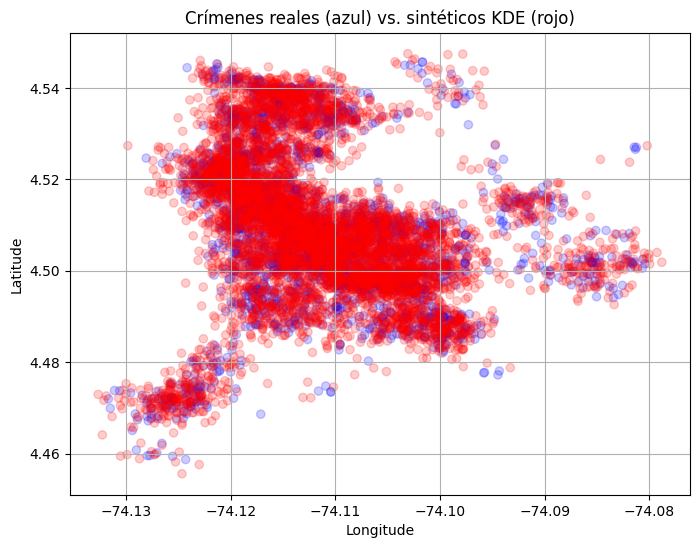

In [22]:
import matplotlib.pyplot as plt

gdf_eventos_real_synt_filter=gdf_eventos_real_synt[gdf_eventos_real_synt['Nombre de la localidad']=='USME']

colors = gdf_eventos_real_synt_filter['source'].map({'real': 'blue', 'synthetic': 'red'})
plt.figure(figsize=(8,6))

plt.scatter(gdf_eventos_real_synt_filter['LONGITUD_X'], gdf_eventos_real_synt_filter['LATITUD_Y'], c=colors, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Crímenes reales (azul) vs. sintéticos KDE (rojo)')
plt.grid(True)
plt.show()

In [23]:
gdf_crime=gpd.read_file('../Data/Bogota/Raw Data/raw_data_2018_2021_200x200_random_synthetic.geojson')

In [24]:
gdf_crime=gdf_crime[gdf_crime.source=='real'].reset_index(drop=True)
gdf_crime.rename(columns={'fecha_crimen':'date'},inplace=True)
gdf_crime=gdf_crime[gdf_crime.date>=datetime(2021, 1, 1)].reset_index(drop=True)

gdf_crime.date.max()

Timestamp('2021-05-31 23:52:01')

In [25]:
gdf_crime[gdf_crime.date>=datetime(2021, 1, 1)]

,date,LONGITUD_X,LATITUD_Y,Nombre de la localidad,source,geometry
0,2021-01-01 03:19:14,-74.110922,4.474780,USME,real,POINT (-74.11092 4.47478)
1,2021-01-01 14:39:37,-74.111620,4.473668,USME,real,POINT (-74.11162 4.47367)
2,2021-01-01 14:51:33,-74.110448,4.473562,USME,real,POINT (-74.11045 4.47356)
3,2021-01-01 06:36:45,-74.110429,4.473425,USME,real,POINT (-74.11043 4.47343)
4,2021-01-01 06:58:12,-74.117041,4.521691,USME,real,POINT (-74.11704 4.52169)
...,...,...,...,...,...,...
12898,2021-05-31 20:28:46,-74.107542,4.743773,SUBA,real,POINT (-74.10754 4.74377)
12899,2021-05-31 16:08:11,-74.120964,4.746010,SUBA,real,POINT (-74.12096 4.74601)
12900,2021-05-31 14:27:23,-74.089036,4.747701,SUBA,real,POINT (-74.08904 4.74770)
12901,2021-05-31 23:52:01,-74.118906,4.753327,SUBA,real,POINT (-74.11891 4.75333)


In [26]:
gdf_city = gpd.read_file("../Data/Bogota/Raw Data/poligonos-localidades.geojson")
gdf_city=gdf_city[gdf_city['Nombre de la localidad']!='SUMAPAZ']
gdf_city.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry
0,CIUDAD BOLIVAR,Acuerdo 14 de 1983,"130002593,080624",19,"{'lon': -74.16195890440652, 'lat': 4.482460265...","MULTIPOLYGON (((-74.18135 4.58892, -74.18092 4..."
1,SUBA,Acuerdo 8 de 1977,"100560477,718254",11,"{'lon': -74.0758452755469, 'lat': 4.7632081213...","MULTIPOLYGON (((-74.03450 4.82547, -74.03489 4..."
2,RAFAEL URIBE URIBE,Acuerdo 117 de 2003,"13834084,806513",18,"{'lon': -74.11336318293525, 'lat': 4.566476900...","MULTIPOLYGON (((-74.12803 4.59254, -74.12829 4..."
3,KENNEDY,Acuerdo 8 de 1977,"38589733,814235",08,"{'lon': -74.15266762383382, 'lat': 4.630347351...","MULTIPOLYGON (((-74.11830 4.63741, -74.11854 4..."
4,USME,Acuerdo 15 de 1993,"215066686,644374",05,"{'lon': -74.14280649581936, 'lat': 4.390025128...","MULTIPOLYGON (((-74.05597 4.50832, -74.05599 4..."


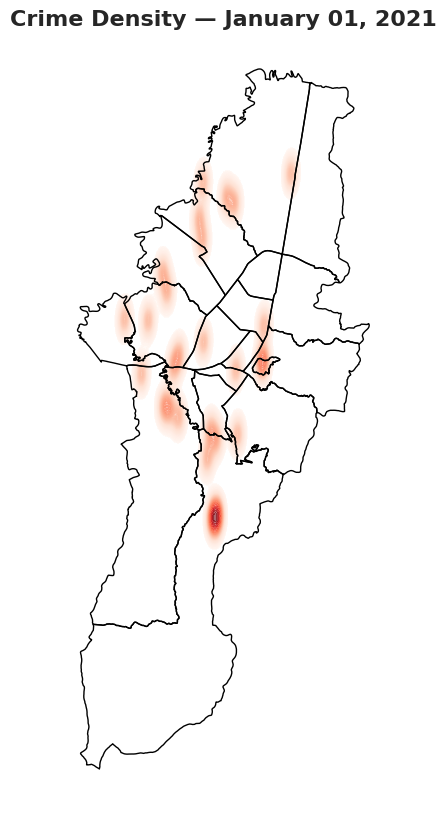

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, FFMpegWriter
from datetime import datetime

# Estilo bonito
sns.set_style("white")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 10)

# Supongamos que tienes:
# gdf_crime: GeoDataFrame con columnas year, month, day y geometry (Point)
# gdf_city: GeoDataFrame con el polígono de la ciudad

# Generar la fecha completa

#gdf_crime['date'] = pd.to_datetime(gdf_crime[['year', 'month', 'day']])
gdf_crime = gdf_crime.sort_values('date')
unique_dates = gdf_crime['date'].dt.date.unique()

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame_number):
    ax.clear()

    current_date = unique_dates[frame_number]
    daily_data = gdf_crime[gdf_crime['date'].dt.date == current_date]

    # Mapa de fondo
    gdf_city.boundary.plot(ax=ax, color="black", linewidth=1)

    # Heatmap KDE
    if len(daily_data) > 0:
        sns.kdeplot(
            x=daily_data.geometry.x,
            y=daily_data.geometry.y,
            fill=True,
            cmap="Reds",
            bw_adjust=0.2,
            levels=100,
            alpha=0.6,
            ax=ax
        )

    ax.set_title(f"Crime Density — {current_date.strftime('%B %d, %Y')}", fontsize=16, weight='bold')
    ax.axis('off')

# Crear animación
ani = FuncAnimation(fig, update, frames=len(unique_dates), interval=500)

# Guardar como .mp4
writer = FFMpegWriter(fps=2, metadata=dict(artist='CrimeMapViz'), bitrate=1800)
ani.save("../Results/crime_heatmap_bogota.mp4", writer=writer, dpi=150)


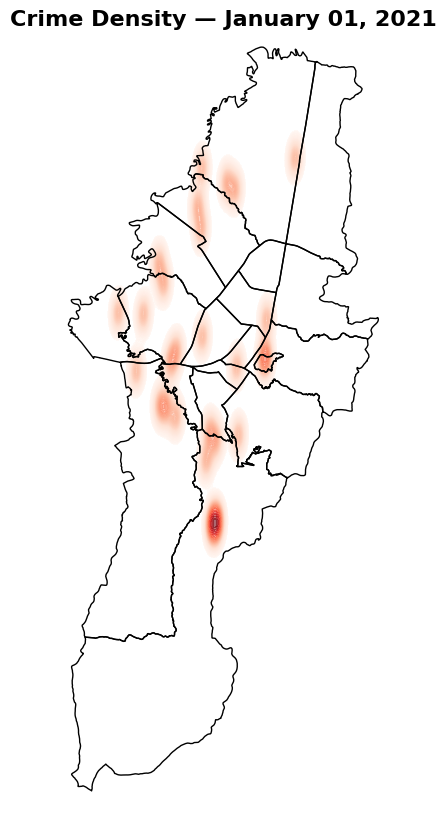

In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, FFMpegWriter
from datetime import datetime

# Calcular los límites fijos del contorno de la ciudad
minx, miny, maxx, maxy = gdf_city.total_bounds
padding = 0.01  # opcional: un pequeño margen
xlim = (minx - padding, maxx + padding)
ylim = (miny - padding, maxy + padding)

#gdf_crime['date'] = pd.to_datetime(gdf_crime[['year', 'month', 'day']])
gdf_crime = gdf_crime.sort_values('date')
unique_dates = gdf_crime['date'].dt.date.unique()

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame_number):
    ax.clear()

    current_date = unique_dates[frame_number]
    daily_data = gdf_crime[gdf_crime['date'].dt.date == current_date]

    # Contorno fijo de la ciudad
    gdf_city.boundary.plot(ax=ax, color="black", linewidth=1)

    # Heatmap KDE
    if len(daily_data) > 0:
        sns.kdeplot(
            x=daily_data.geometry.x,
            y=daily_data.geometry.y,
            fill=True,
            cmap="Reds",
            bw_adjust=0.2,
            levels=100,
            alpha=0.6,
            ax=ax
        )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f"Crime Density — {current_date.strftime('%B %d, %Y')}", fontsize=16, weight='bold')
    ax.axis('off')

# Crear animación
ani = FuncAnimation(fig, update, frames=len(unique_dates), interval=500)

# Guardar como .mp4
writer = FFMpegWriter(fps=2, metadata=dict(artist='CrimeMapViz'), bitrate=1800)
ani.save("crime_heatmap_bogota.mp4", writer=writer, dpi=150)

In [8]:
gdf_crime_raw=pkl.load(open("Chicago/Raw Data/Test_chicago.pkl", "rb"))
gdf_crime=gpd.GeoDataFrame()
gdf_crime['x']=gdf_crime_raw.xcoords
gdf_crime['y']=gdf_crime_raw.ycoords
gdf_crime['fecha_crimen']=gdf_crime_raw.times_datetime()
gdf_crime['geometry']=[Point(x,y) for x,y in zip(gdf_crime.x,gdf_crime.y)]
gdf_crime.crs='EPSG:26971'
gdf_crime = gdf_crime.to_crs(epsg=4326)
gdf_crime.rename(columns={'fecha_crimen':'date'},inplace=True)
gdf_crime=gdf_crime[gdf_crime.date>=datetime(2023, 5, 1)].reset_index(drop=True)

gdf_city=gpd.read_file('Chicago/Raw Data/chicago_community_filtrada_planas.geojson')
gdf_city = gdf_city.to_crs(epsg=4326)

<ipython-input-8-ee55bab09fab>:6: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_crime['geometry']=[Point(x,y) for x,y in zip(gdf_crime.x,gdf_crime.y)]


<ipython-input-39-70550e6b872f>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


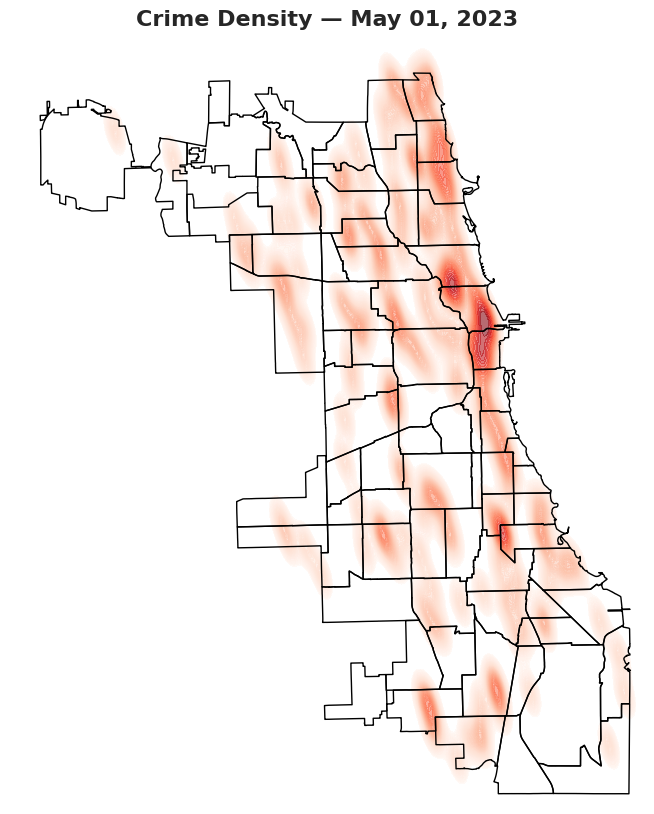

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, FFMpegWriter
from datetime import datetime

# Estilo bonito
sns.set_style("white")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (10, 10)

# Supongamos que tienes:
# gdf_crime: GeoDataFrame con columnas year, month, day y geometry (Point)
# gdf_city: GeoDataFrame con el polígono de la ciudad

# Generar la fecha completa

#gdf_crime['date'] = pd.to_datetime(gdf_crime[['year', 'month', 'day']])
gdf_crime = gdf_crime.sort_values('date')
unique_dates = gdf_crime['date'].dt.date.unique()

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))



# Normalización para color
norm = Normalize(vmin=0, vmax=0.015)  # ajusta el vmax según los datos
cmap = cm.get_cmap("Reds")

def update(frame_number):
    ax.clear()

    current_date = unique_dates[frame_number]
    daily_data = gdf_crime[gdf_crime['date'].dt.date == current_date]

    # Mapa de fondo
    gdf_city.boundary.plot(ax=ax, color="black", linewidth=1)

    # Heatmap KDE
    if len(daily_data) > 0:
        sns.kdeplot(
            x=daily_data.geometry.x,
            y=daily_data.geometry.y,
            fill=True,
            cmap="Reds",
            bw_adjust=0.2,
            levels=100,
            alpha=0.6,
            ax=ax
        )

    ax.set_title(f"Crime Density — {current_date.strftime('%B %d, %Y')}", fontsize=16, weight='bold')
    ax.axis('off')

    # Colorbar fija
    cbar_ax.clear()
    cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('Crime Density', fontsize=12)
    cb.ax.tick_params(labelsize=10)

# Crear animación
ani = FuncAnimation(fig, update, frames=len(unique_dates), interval=500)

# Guardar como .mp4
writer = FFMpegWriter(fps=2, metadata=dict(artist='CrimeMapViz'), bitrate=1800)
ani.save("crime_heatmap_chicago.mp4", writer=writer, dpi=150)


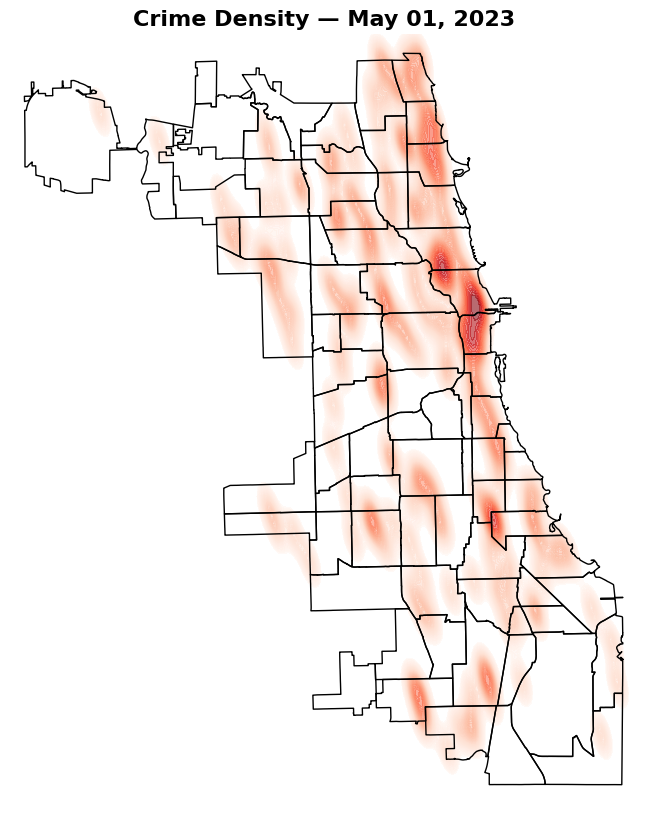

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, FFMpegWriter
from datetime import datetime

# Calcular los límites fijos del contorno de la ciudad
minx, miny, maxx, maxy = gdf_city.total_bounds
padding = 0.01  # opcional: un pequeño margen
xlim = (minx - padding, maxx + padding)
ylim = (miny - padding, maxy + padding)

#gdf_crime['date'] = pd.to_datetime(gdf_crime[['year', 'month', 'day']])
gdf_crime = gdf_crime.sort_values('date')
unique_dates = gdf_crime['date'].dt.date.unique()

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame_number):
    ax.clear()

    current_date = unique_dates[frame_number]
    daily_data = gdf_crime[gdf_crime['date'].dt.date == current_date]

    # Contorno fijo de la ciudad
    gdf_city.boundary.plot(ax=ax, color="black", linewidth=1)

    # Heatmap KDE
    if len(daily_data) > 0:
        sns.kdeplot(
            x=daily_data.geometry.x,
            y=daily_data.geometry.y,
            fill=True,
            cmap="Reds",
            bw_adjust=0.2,
            levels=100,
            alpha=0.6,
            ax=ax
        )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(f"Crime Density — {current_date.strftime('%B %d, %Y')}", fontsize=16, weight='bold')
    ax.axis('off')

# Crear animación
ani = FuncAnimation(fig, update, frames=len(unique_dates), interval=500)

# Guardar como .mp4
writer = FFMpegWriter(fps=2, metadata=dict(artist='CrimeMapViz'), bitrate=1800)
ani.save("crime_heatmap_chicago.mp4", writer=writer, dpi=150)